In [6]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence


from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [7]:
%matplotlib inline
DATA = r'C:\Users\User\Documents\GitHub\work\practical-statistics-for-data-scientists\data\\'

In [8]:
LUNG_CSV = DATA + 'LungDisease.csv'
HOUSE_CSV = DATA + 'house_sales.csv'

# Простая линейная регрессия

In [9]:
lung = pd.read_csv(LUNG_CSV)
lung.head(14)

,PEFR,Exposure
0,390,0
1,410,0
2,430,0
3,460,0
4,420,1
5,280,2
6,420,2
7,520,2
8,610,3
9,590,3


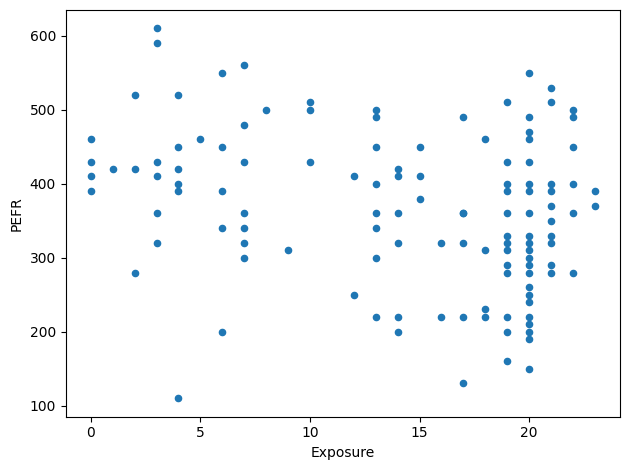

In [10]:
lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In [11]:

rgr1 = LinearRegression()
rgr1.fit(lung[['Exposure']], lung.iloc[:,0])

print(f'Свободный член: {rgr1.intercept_: .3f}')
print(f'Угол наклона: {rgr1.coef_[0]: .3f}')

Свободный член:  424.583
Угол наклона: -4.185


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


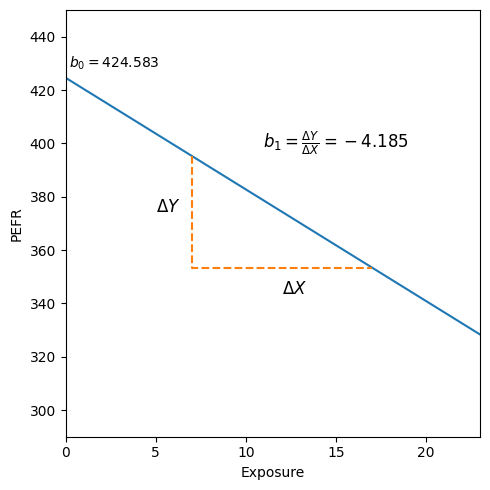

In [12]:
figure, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(0,23)
ax.set_ylim(290,450)

ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')

ax.plot(np.arange(0,24), rgr1.predict(np.arange(0,24).reshape(-1,1)))
x = np.array([7,17]).reshape(-1,1)
y = rgr1.predict(x)
ax.text(0.2,430, f'$b_0={rgr1.intercept_: .3f}$',
          verticalalignment='center')
ax.text(15,400, r'$b_1= \frac{\Delta Y}{\Delta X}$' + f'$={rgr1.coef_[0]: .3f}$',
          verticalalignment='center', horizontalalignment='center', size='larger')

ax.plot((x[0],x[0],x[1]), (y[0],y[1],y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')

plt.tight_layout()
plt.show()

In [13]:
fitted = rgr1.predict(lung[['Exposure']])
residuals = lung['PEFR'] - fitted #рассчитываем остатки

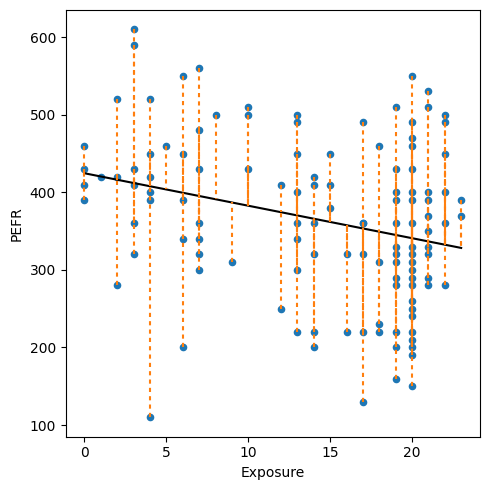

In [14]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(5,5))
ax.plot(lung['Exposure'], fitted, color='black')
ax.plot((lung['Exposure'],lung['Exposure']), (lung['PEFR'], fitted), color='C1',
        linestyle=(0, (2,2)))

plt.tight_layout()
plt.show()

In [15]:
house = pd.read_csv(HOUSE_CSV, sep='\t')
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']
house[subset].head()

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,300805.0,2400,9373,3.00,6,7
2,1076162.0,3764,20156,3.75,4,10
3,761805.0,2060,26036,1.75,4,8
4,442065.0,3200,8618,3.75,5,7
5,297065.0,1720,8620,1.75,4,7


In [16]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f"Свободный член: {house_lm.intercept_: .3f}")
print("Коэффициенты:")
for name, coef in zip(predictors, house_lm.coef_):
    print(f'{name}: {coef: .3f}')

Свободный член: -521871.368
Коэффициенты:
SqFtTotLiving:  228.831
SqFtLot: -0.060
Bathrooms: -19442.840
Bedrooms: -47769.955
BldgGrade:  106106.963


In [17]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'R2: {r2: .4f}')
print(f'RMSE: {RMSE: .0f}')

R2:  0.5406
RMSE:  261220


In [18]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:40:40   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

In [19]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:40:40   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

In [20]:
house[predictors].head()

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction
1,2400,9373,3.00,6,7,Multiplex,2,0,1991,0,False
2,3764,20156,3.75,4,10,Single Family,1,1452,2005,0,True
3,2060,26036,1.75,4,8,Single Family,1,900,1947,0,False
4,3200,8618,3.75,5,7,Single Family,1,1640,1966,0,False
5,1720,8620,1.75,4,7,Single Family,1,0,1948,0,False


In [21]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201472
 BldgGrade: 137159.5602261984
 YrBuilt: -3565.424939249441
 Bedrooms: -51947.38367361348
 Bathrooms: 42396.16452771906
 PropertyType_Townhouse: 84479.1620329987
 SqFtFinBasement: 7.046974967553979
 PropertyType_Single Family: 22912.05518701765


## Взвешенная регрессия

In [22]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Weight'] = house.Year - 2005
house['Weight'].head()

1    9
2    1
3    2
4    3
5    8
Name: Weight, dtype: int64

In [23]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome],
                             sample_weight=house['Weight'])

df = pd.concat([
    pd.DataFrame({
    'predictors': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_
    }),
    pd.DataFrame({
    'predictors': ['intercept'],
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_
    }
    )]
)
df.head(7)

,predictors,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


In [24]:
fitted = house_wt.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'R2: {r2: .4f}')
print(f'RMSE: {RMSE: .0f}')

R2:  0.5382
RMSE:  261908


## Факторные переменные

In [25]:
house.groupby(by=house['PropertyType']).describe()

SalePrice                                                     \
                  count           mean            std       min        25%   
PropertyType                                                                 
Multiplex         257.0  499526.498054  191583.316876  120000.0  359950.00   
Single Family   20720.0  517038.039382  358494.857489   10480.0  326000.00   
Townhouse        1710.0  398756.626901  135964.159640    3000.0  316777.25   

                                              PropertyID                ...  \
                    50%       75%         max      count          mean  ...   
PropertyType                                                            ...   
Multiplex      478210.0  600000.0   1675000.0      257.0  4.357707e+09  ...   
Single Family  429327.0  599950.0  11000000.0    20720.0  4.650940e+09  ...   
Townhouse      379900.0  450000.0   2060000.0     1710.0  4.896996e+09  ...   

                 Year           Weight                                     \
                  75%     max    count      mean       std  min  25%  50%   
PropertyType                                                                
Multiplex      2008.0  2015.0    257.0  2.638132  2.357954  1.0  1.0  2.0   
Single Family  2009.0  2015.0  20720.0  2.976786  2.284232  1.0  1.0  2.0   
Townhouse      2009.0  2015.0   1710.0  3.023392  2.078768  1.0  1.0  2.0   

                          
               75%   max  
PropertyType              
Multiplex      3.0  10.0  
Single Family  4.0  10.0  
Townhouse      4.0  10.0  

[3 rows x 160 columns]

In [26]:
print(pd.get_dummies(house['PropertyType']).head(6))

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1


In [27]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))
#Удаляем первый столбец, чтобы избавиться от мультиколениарности

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [36]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']
X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X,house[outcome])

print(f'Свободный член: {house_lm_factor.intercept_: .3f}')
print('Коэффициенты: ')
for name, coef in zip(X.columns,house_lm_factor.coef_):
    print(f'{name}: {coef}')

print(f'\nR2: {r2_score(house[outcome], house_lm_factor.predict(X)): .4f}')
print(f'MSE: {mean_squared_error(house[outcome], house_lm_factor.predict(X)): .0f}')

Свободный член: -446841.366
Коэффициенты: 
SqFtTotLiving: 223.37362892503862
SqFtLot: -0.07036798136812905
Bathrooms: -15979.013473415307
Bedrooms: -50889.732184830085
BldgGrade: 109416.30516146208
PropertyType_Single Family: -84678.21629549318
PropertyType_Townhouse: -115121.97921609206

R2:  0.5415
MSE:  68106217759


In [37]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())
#Кол-во домов с таким-то почтовым индексом,
#хотим их сгрупировать, чтобы факторных переменных было не так много

         98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
ZipCode    788    671    641    620    619    614    575    517    513    502   

         ...  98051  98024  98354  98050  98057  98288  98224  98068  98113  \
ZipCode  ...     32     31      9      7      4      4      3      1      1   

         98043  
ZipCode      1  

[1 rows x 80 columns]


In [40]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
 